<t><h1><ins>Disaster Tweet Classification Challange - Frank Mitchell</ins></h1><br><br>

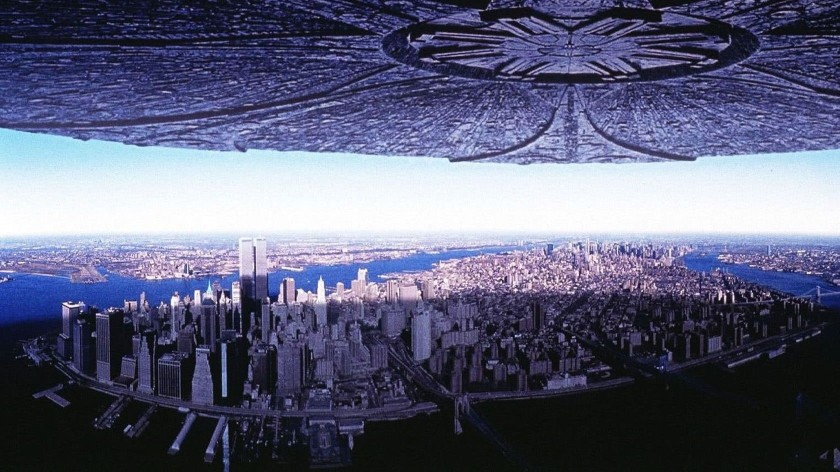

<h2><ins>1. Introduction</ins></h2><br>


As an increasingly popular platform for up-to-date news around the world, Twitter has become synonymous with real-time event monitoring. However, it relies on the (often) short description of events from everyday members of the public. These short messages contain colloqualisms, shorthand and acronymns that can be deeply ambigious. 

Take the following tweets,

`Sonar Festival is pure, absolute fire!!!`<br>


`A massive fire is destroying half the world right now!!`<br>

Both make refernce to the concept of `fire`, with one completely innocous, and the other a vital peice of information for the public at large. By using machine learning and neural network techniques we aim to identify tweets that make reference to genuine disasters.<br>

<br>


<h3><ins>1.1 Libraries</ins></h3><br>

First we need to import the necessary libraries, an `NLP` package with great functionality and versatility, the `Natural Language ToolKit (NLTK)`.

---


In [1]:
!pip install tensorflow_datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import re
import nltk
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, naive_bayes
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MaxAbsScaler
from scipy import stats
from sklearn.metrics import make_scorer, roc_auc_score
from scipy.linalg import svd
from numpy import diag
from scipy.sparse import csr_matrix

from numpy import zeros
from sklearn import svm

from nlp_functions import *


     |████████████████████████████████| 3.3 MB 2.7 MB/s 


<br>

<h3><ins>1.2 Set Random Seed</ins></h3><br>

A short piece of boilerplate code to set our random seeds and ensure reproducability of results.

<br>

In [2]:
np.random.seed(500)

<br>

<h3><ins>1.3 TensorWrapper Functions</ins></h3><br>

These functions allow us to call the `.map` method on a tensorflow dataset. 

They are held here, rather than in the utility script, as the `tensorflow encoder` needs to be accessed by the model and passing it through the wrapper parameters was just as messy. 

All other custom functions are imported from our utility script, `nlp_functions`.<br>
<br>

In [3]:
def encode_train(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

def encode_map_fn_train(text, label):
    return tf.py_function(encode_train, inp=[text, label], Tout=(tf.int64, tf.int64))

def encode_unseen(text_tensor):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, 1

def encode_map_fn_unseen(text):
    return tf.py_function(encode_unseen, inp=[text], Tout=(tf.int64, 1))

<br>

<h2><ins>2. Initial data exploration</ins></h2><br>

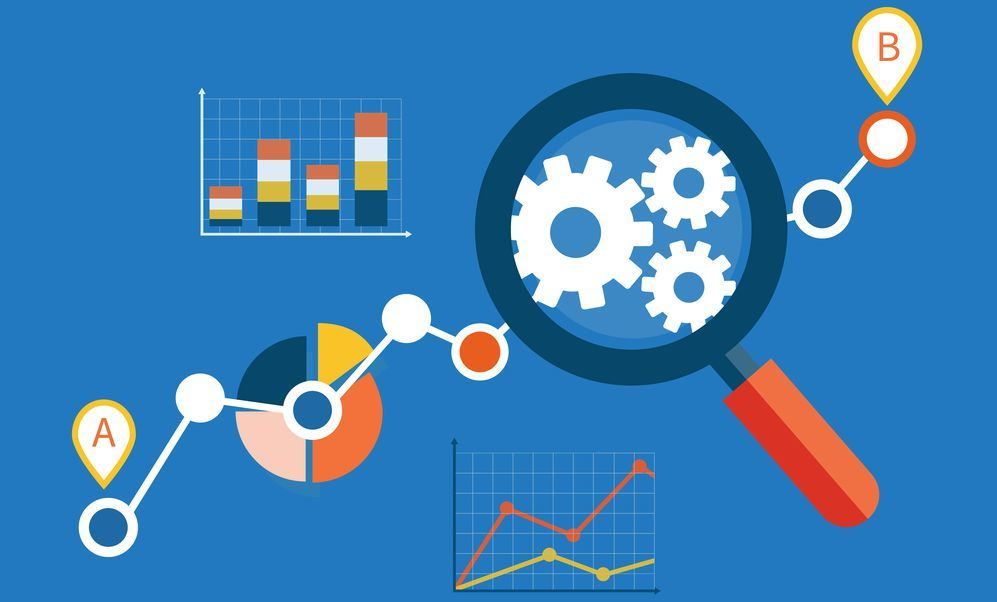

<br>

With our libraries prepared it is now time to import the data and begin our initial examination. Our aim here is to check the varioua features included within the data and take a closer look at our target variable `target`. 

We begin by loading the data and examining the top 5 instances. 

<br>

<h3><ins>2.1. Import data</ins></h3><br>

A simple call to an in-built Pandas method to load the data and check how many values appear in our target column. 

As we can see, there are only two possible values for our target variable, making this a `binary classification` task. 

<br>



In [4]:
disaster_original = pd.read_csv('../input/nlp-getting-started/train.csv')
disaster_original.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
disaster_original['target'].unique()

array([1, 0])

In [6]:
disaster_original.shape

(7613, 5)

<br>

It's also important that we import the unseen data so that all transformations can be similary applied. 

<br>

In [7]:
unseen_data = pd.read_csv('../input/nlp-getting-started/test.csv')
unseen_id = pd.read_csv('../input/nlp-getting-started/test.csv')

<br>

<h3><ins>2.2. Drop Columns</ins></h3><br>

The `id`, `keyword` and `location` columns are all entirley null, and intuitively shouldn't add any value to the model's ability to classify the body of the tweet as disaster `1` or no disaster `0`.

We drop the columns and recheck the first five entries. 

<br>

In [8]:
disaster_original = drop_columns(disaster_original)
unseen_data = unseen_data.drop(columns=['id', 'keyword', 'location'])
disaster_original.head(5)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


<br> 

The unseen data includes two tweets that consist of blank strings, causing issues with the `Recurrent Neural Network` tweet vectors, and so must be replaced with at least one character. In this instance we have chosen to replace the blank string with the word `empty`.

<br>

In [9]:
unseen_data['text'] = unseen_data['text'].replace("", "empty")

<br>

<h3><ins>2.3. Target Variable Distribution</ins></h3><br>

With any classification task we need to check the distribution of our dependent variable. We want to ensure that our target is evenly distributed amongst the training and validation sets. Its important that we make a copy of the data to work on, this keeps the original dataset completely untouched. 

<br>


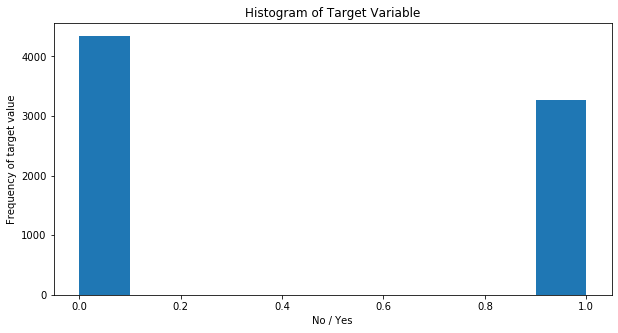

In [10]:
disaster_tweets = disaster_original.copy()

plt.figure(figsize=(10, 5))
plt.hist(disaster_tweets['target'])
plt.title('Histogram of Target Variable')
plt.xlabel('No / Yes')
plt.ylabel('Frequency of target value')
plt.show()

<br>

<h3><ins>2.4. Startified Sampling</ins></h3><br>

The slight imbalance of target values above (in favour of no disaster) indicate that we should conduct `Stratified Sampling`. Using pre-built `SKLearn` methods this technique maintains the same distribution of independent variables throughout each of our stratified samples (training and validation). 

Here we opted for an initial `80/20` split due to the relatively low number of tweets, however this parameter can have a direct affect on model accruacy and should be considered in the same respect as every other hyperparameter. 

<br>

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(disaster_tweets, disaster_tweets['target']):
    
    strat_training_set = disaster_tweets.loc[train_index]
    strat_testing_set = disaster_tweets.loc[test_index]

<br>

With our samples ready we can now visualise the distribution of the dependent variable across each of these samples and compare them with the original dataset. 

<br>

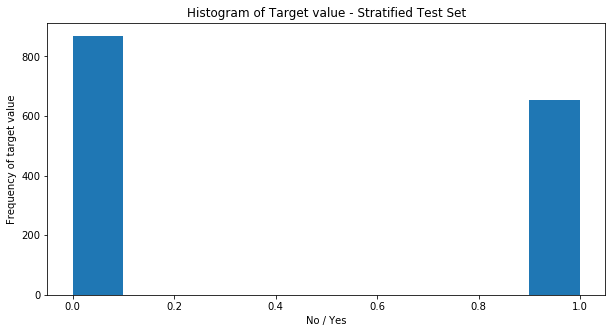

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(strat_testing_set['target'])
plt.xlabel('No / Yes')
plt.ylabel('Frequency of target value')
plt.title('Histogram of Target value - Stratified Test Set')
plt.show()

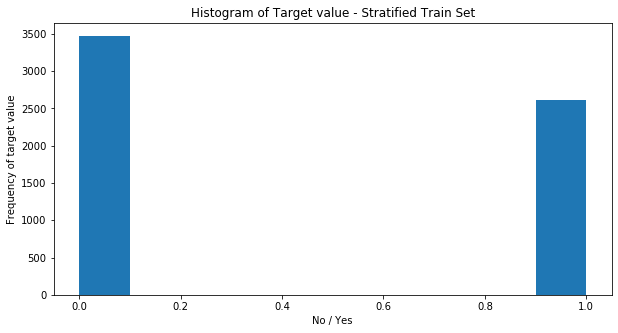

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(strat_training_set['target'])
plt.xlabel('No / Yes')
plt.ylabel('Frequency of target value')
plt.title('Histogram of Target value - Stratified Train Set')
plt.show()

<br>

<h3><ins>2.5. Text preprocessing</ins></h3><br>

To begin to understand any text data it's important to represent the data in an appropriate format. This means taking ech tweet and embedding the text in vector space using the `TF-IDF (Term Frequency- Invert Document Frequency)` distance metric. `TF-IDF` creates a sparse matrix of `documents * words`, with a words TF-IDF value assigned to each field. 

In order to embed tweets we first need to clean the text, which involves a number of steps;

1. Make all text lowercase.
2. Tokensie the text (turn each tweet into a list of string tokens).
3. Remove stopwords (removing redundant words like 'and', 'the' or 'a').
4. Stemming the text (taking each word down to its root).

In order to ensure easy and efficient reporducability, these formatting techniques are performed by our custom function. 

<br>

In [14]:
strat_training_set = pre_process(strat_training_set)
strat_testing_set = pre_process(strat_testing_set)
unseen_data = pre_process(unseen_data)

<br>

<h3><ins>2.6. Splitting the Stratified Samples</ins></h3><br>

Our final task in this part of the data processing simply invovles seperting our independent and dependent variables. 

<br>

In [15]:
X_train = strat_training_set.drop(columns=['target'])
Y_train = strat_training_set['target']

X_test = strat_testing_set.drop(columns=['target'])
Y_test = strat_testing_set['target']

<h2><ins>3. Word Vectorisation</ins></h2><br><br>

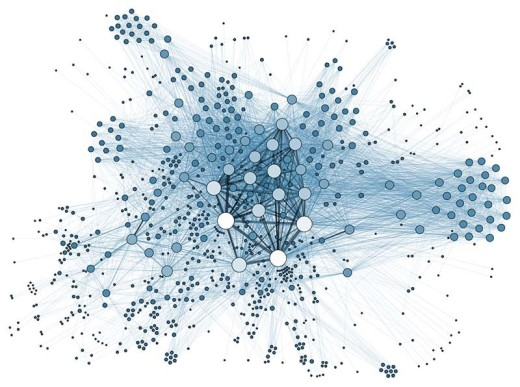

<br>

<h3><ins>3.1 TF-IDF Vectoriser</ins></h3><br>

As an initial method of numerically representing each tweet we opted for TF-IDF, which measure the count of words in a particular document but balances this with the appearence of that word over the whole corpus (every tweet included in the data). 

An alternative (and possibly better vector technique) would be to uslise a `word2vec` model to embed our tweets and assign vector values. This is something we plan to explore in the future, however the ease with which we can implement TF-IDF using built in `SKLearn` classes and functions make it a good starting point to begin fitting our model. 

To achieve this vectorisation we first preprocess all of our tweets (seen and unseen data) and instantiate a `TDidfVectorizer` object which will perform the necessary calculations to assign `TF-IDF` values to each of our documents. We then use this trained model to assign features to our stratified samples. 

<br>

In [16]:
disaster_tweets = pre_process(disaster_tweets)

tf_idf_vect = TfidfVectorizer(max_features=300, sublinear_tf=True)
tf_idf_vect.fit(disaster_tweets['text'])

X_train_tfidf = tf_idf_vect.transform(X_train['text'])
X_test_tfidf = tf_idf_vect.transform(X_test['text'])

<br>

This results in a sparse matrix of numerical values to represent each of the tweets. Using this sparse matrix we can visualise our tweets in vector space and assign a hue based on the target variable. 

<br>

<br>

<h3><ins>3.2. Visualise the Vectors</ins></h3><br>

Using `Singular Value Decomposition` we can reduce the number of dimensions in the data and visualise the tweets in three-dimensional vector space, colouring each instance based on the target variable. 

<br>

In [17]:
tSVD = TruncatedSVD(n_components=3)
data_3d = tSVD.fit_transform(X_train_tfidf)

svd_df = pd.DataFrame()
svd_df['svd_one'] = data_3d[:, 0]
svd_df['svd_two'] = data_3d[:, 1]
svd_df['svd_three'] = data_3d[:, 2]


<Figure size 432x288 with 0 Axes>

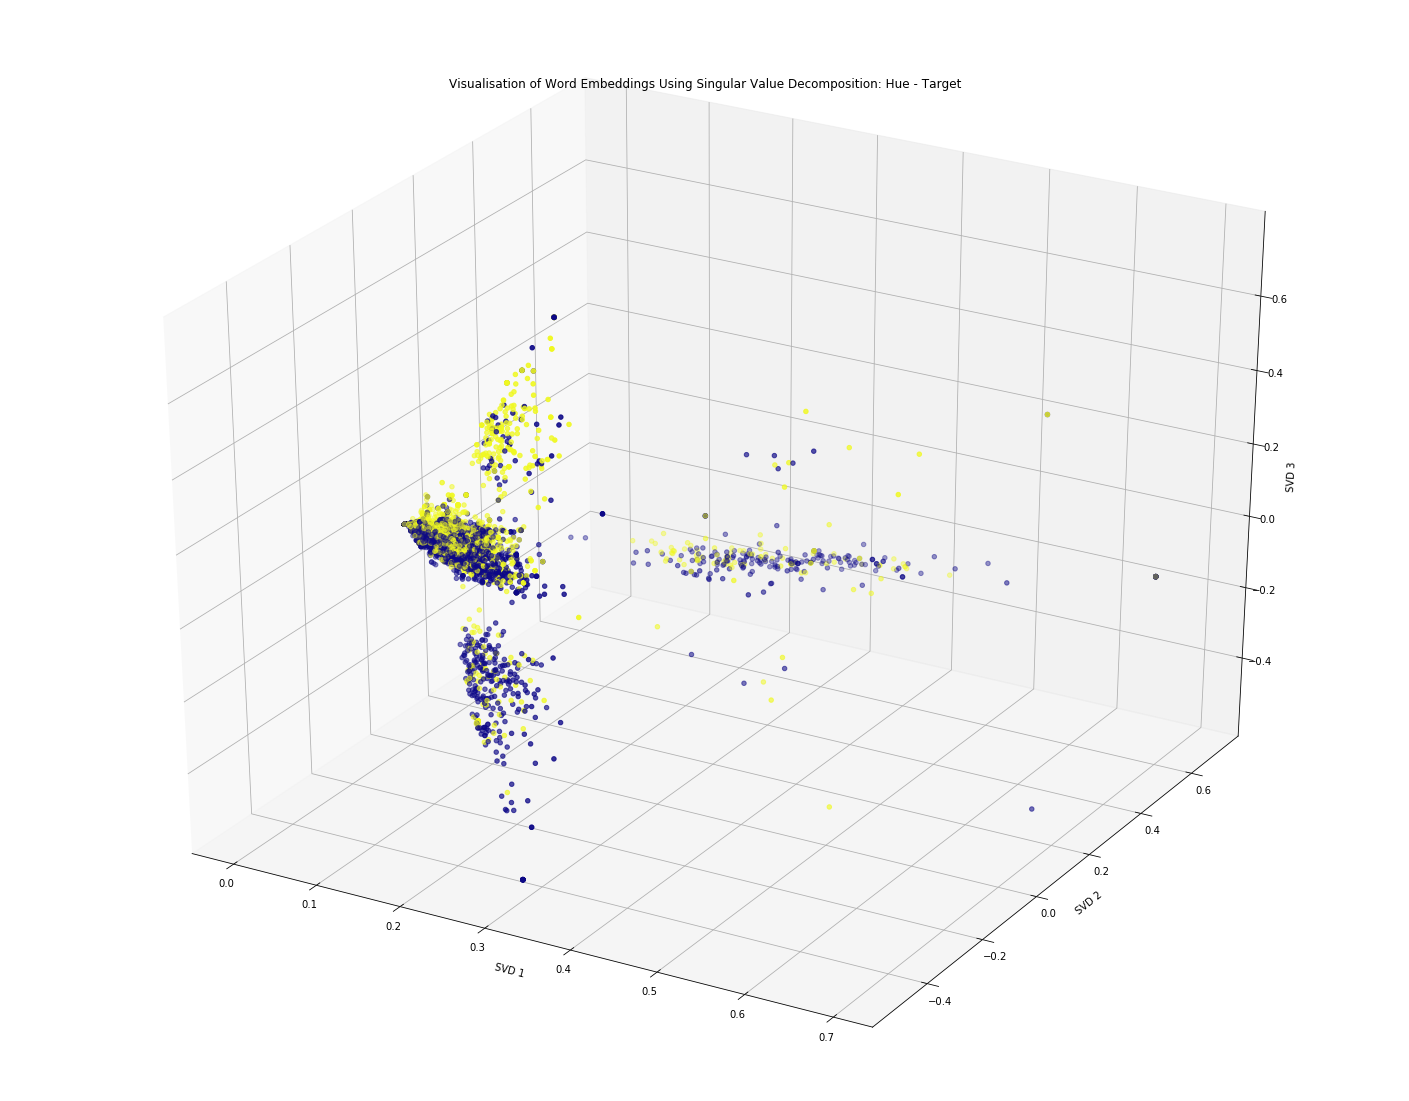

In [18]:
plot_vectors(svd_df, strat_training_set)

<br>

From our visulalisation we can see the `TF-IDF` has split the data quite well, showing a relatively clear split between our target values. 

This graph further evidences the effectiveness of word embeddings as a means of facilitating learning from unstructred text data. 

<br>

<br>

<h2><ins>4. Building Models</ins></h2><br>

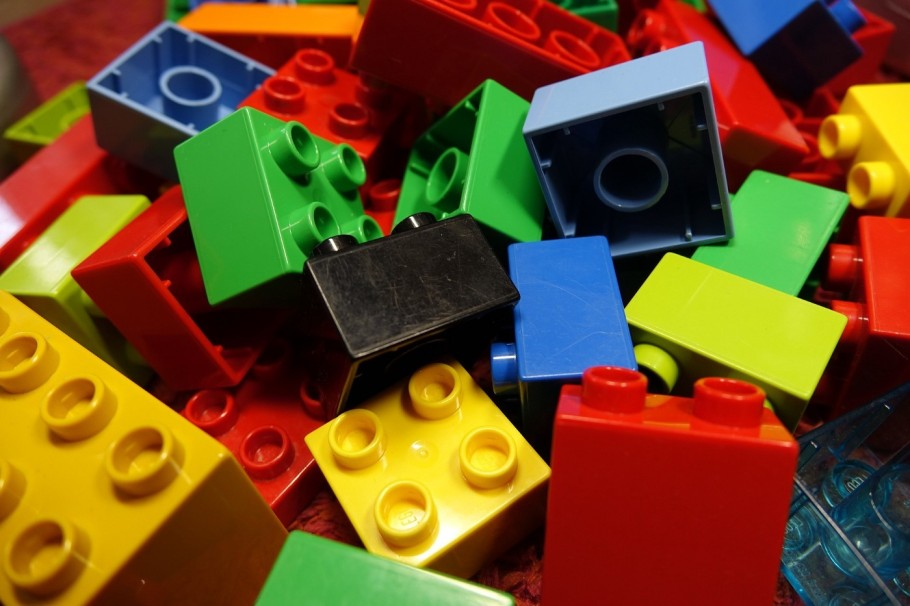


<h3><ins>4.1. Model 1 - Naive Bayes </ins></h3><br>

To begin our analysis we considered `Naive Bayes` as an initial model, a popular classifier for unstructured text with proven ability in the field. 

`Naive Bayes` performs well with a small amount of data and uses prior knowledge to calculate a posterior probability, represented by a probability distribution which reflects the likelihood that a specific instance belongs to a particular class.

The algorithm is said to be "naive" as it makes some assumptions about our environement; firstly, each variable is statistically independent of one another, and secondly, each feature has equal importance. These two prerequisites are very rarely found in the real world, however with these simplyfing assumptions we can infer the likelhood of a particular event using the foundational theory of Baysian decision making and conditional probilities.  

<br>


<h4><ins>4.1.1 Baseline Model - Naive Bayes</ins></h4><br>

With our data prepared we can instantiate a `Naive Bayes` classifier by invoking an `SKLearn` class, initially maintaining default parameters to establish a baseline performance. We will use this baseline performance as a means of deciding whether to further explore the parameter space of `Naive Bayes`, or consider a different model for our problem.

<br>

In [19]:
nb = naive_bayes.MultinomialNB()
nb.fit(X_train_tfidf, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [20]:
nb_validation_predictions = nb.predict(X_test_tfidf)
nb_training_predictions = nb.predict(X_train_tfidf)

In [21]:
print(f"Naive Bayes Basline Validation Accuracy: {accuracy_score(nb_validation_predictions, Y_test) * 100}")
print(f"Naive Bayes Basline Training Accuracy: {accuracy_score(nb_training_predictions, Y_train) * 100}")

Naive Bayes Basline Validation Accuracy: 76.49376231122784
Naive Bayes Basline Training Accuracy: 76.7816091954023


<br>

<h4><ins>4.1.2 Baseline Results - Naive Bayes</ins></h4><br>

Our baseline `Naive Bayes` model performed relatively well (although there is plenty of room for improvement) achieving `76.49%` accuracy on the unseen validation data. What's intersting is that our training accuracy has a very similiar value to our validation accuracy, indicating that the model is indeed a good fit. 

It may be that we are already pushing the limits of accuracy with our limited dataset, `NLP` tasks traditionally perform better when exposed to more data.

The `GuassianNB` object also cannot be tuned using `Gridsearch` or `RandomSearch` as the only arguments the object accepts are alternative `priors`. For this reason we decided to move forward with a different model implementation. 

<br>

---


<br>

<h3><ins>4.2 Model 2 - Support Vector Machines</ins></h3><br>

Our next consideration for classifying tweets was inspired by the visualisation of our data points in vector space. As we can see from the graph above, the data has been nicely segmented by our `Singular Value Decompsition`, with a clear plane discernable that looks to be a good fit for our data. 

As a binary classifier for unstructured text, `Support Vector Machines` also has a good reputation for handling this type of problem. The model aims to create a seperating hyperplane between the classes in the data, acting as our decision boundary for new, unseen data. 

The data points that lie on the threshold of this hyperplane are known as `support vectors`, and we are aiming to maximise the margin between these `support vectors` (for each class) and the seperating hyperplane. The algorithm makes predictions by taking the dot product of our weights and the instance inputs, feeding this to a simple activation function (such as `sigmoid`) and receiving a class label as output. 

`Support Vector Machines` finds the correct weights and sloping factor to disect our data with the optimum seperating hyperplane. 


One other point to note is that `Support Vector Machines` is very sensitive to feature scaling, so we conduct `MinMaxScaling` on our features.

<br>



In [22]:
scaler = MaxAbsScaler()
X_train_svm_scaled = scaler.fit_transform(X_train_tfidf)
X_test_svm_scaled = scaler.fit_transform(X_test_tfidf)

<br>

<h4><ins>4.2.1 Changing the Labels - Support Vector Machines</ins></h4><br>

With `Support Vector Machines` we need to change the labels to `-1` and `1` (as oppossed to `0` and `1`). This is to make the math more manageable by allowing us to express the margin (or how close a data point is to the seperating hyperplane) with a single equation. 

<br>

In [23]:
Y_train_svm = pd.Series(np.where(Y_train == 0, -1, 1))
Y_test_svm = pd.Series(np.where(Y_test == 0, -1, 1))

<br>

<h4><ins>4.2.2. Baseline Model - Support Vector Machines</ins></h4><br>

With our labels prepared and the features vectorised we can go ahead and fit our first `Support Vector Machine` model using the default parameters. Provided we have an acceptable baseline we can further explore the paramter space within the model. 

As evidenced by our accuracy results below, `Support Vector Machines` is an even better fit to our data, maintaining a small difference between training and validation, and scoring a higher accuracy overall. This improved predictive power warrants further exploration of the parameter space. 

<br>


In [24]:
svm_ = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
svm_.fit(X_train_svm_scaled, Y_train_svm)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [25]:
svm_validation_prediction = svm_.predict(X_test_svm_scaled)
svm_training_predictions = svm_.predict(X_train_svm_scaled)

In [26]:
print(f"Support Vector Machines - Training Accuracy: {accuracy_score(svm_training_predictions, Y_train_svm)}")
print(f"Support Vector Machines - Validation Accuract: {accuracy_score(svm_validation_prediction, Y_test_svm)}")

Support Vector Machines - Training Accuracy: 0.7796387520525452
Support Vector Machines - Validation Accuract: 0.7806959947472094


<br>

<h4><ins>4.2.3 Random Search CV - Support Vector Machines</ins></h4><br>

Having found a model that provides an acceptable baseline accuracy, we can further explore the depths of the model's paramter space using `RandomSearchCV`. This `SKLearn` object allows us to easily test a wide range of hyperparamter values, record the results, and choose the best fitting model for our data. 

To conduct a `RandomSearch` we simply set up a parameter grid (a dictionary containing hyperparameter values for the `RandomSearch` to iterate over). Once complete the best model is saved into our instantiated `RandomSearch` object. 

For our `RandomSearch` we are going to explore three parameters, `C`, `gamma` and `tol`:

1. C: This is a regularisation parameter (a technique used to induce a smoothing effect on our function and avoid overfitting.

2. Gamma: This parameter is the kernel coefficient, used to configure the sensitivity to differences in feature vectors.

3. Tol: Tolerance for stopping criterion 

Due to the time-intensive nature of Random Search we have opted to explore only these three parameters. 

---


<b><i>For the sake of compute and process time I have included the code block for the Random Search below. This search yielded the following results:</i></b>
    
    1. C = 3.2291456156839677
    2. gamma = 0.4856666290873001,
    4. tol = 0.7120239961045746
    

<b><i>These parameter values were used to fit the model below</i></b>


---



`rand_grid = {
    "C": stats.uniform(2, 10),
    "gamma": stats.uniform(0.1, 1),
    "tol": stats.uniform(0.1, 1)
}`

`scorer = make_scorer(roc_auc_score)
 svm_rand = svm.SVC()
 rand_search = RandomizedSearchCV(svm_rand, param_distributions=rand_grid,
                                cv=10, scoring=scorer,
                                return_train_score=True)
 search = rand_search.fit(X_train_svm_scaled, Y_train_svm)`


---

<br>

In [27]:
svm_rand_opt_2 = svm.SVC(C=3.2291456156839677,
                      gamma=0.4856666290873001,
                        tol=0.7120239961045746,
                        kernel='rbf')
svm_rand_opt_2.fit(X_train_svm_scaled, Y_train_svm)

SVC(C=3.2291456156839677, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.4856666290873001, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.7120239961045746, verbose=False)

In [28]:
svm_rand_valid_predictions = svm_rand_opt_2.predict(X_test_svm_scaled)
svm_rand_train_predictions = svm_rand_opt_2.predict(X_train_svm_scaled)

In [29]:
print(f"Support Vector Machines - Training Accuracy: {accuracy_score(svm_rand_train_predictions, Y_train_svm)}")
print(f"Support Vector Machines - Validation Accuract: {accuracy_score(svm_rand_valid_predictions, Y_test_svm)}")

Support Vector Machines - Training Accuracy: 0.8715927750410509
Support Vector Machines - Validation Accuract: 0.7806959947472094


<br>

<h4><ins>4.2.3 Interpreting Random Search Best Model Results - Support Vector Machines</ins></h4><br>

With our optimised parameters we have increased our accuracy on the validation data by a small margin. What's intersting is that our gap between training and validation has lengthened considerably, indicating that these parameters are actually slightly overfitting. 

This could indicate that the model would benefit from further exploiration of the `C` parameter to induce further regularisation and induce some smoothing over our predictive function. Further measures to mitigate this effect could be addding more data or reducing the complexity of the model through experimentation with different `kernels`. 



<br>

<br>

<h2><ins>5. Recurrent Neural Network</ins></h2><br>

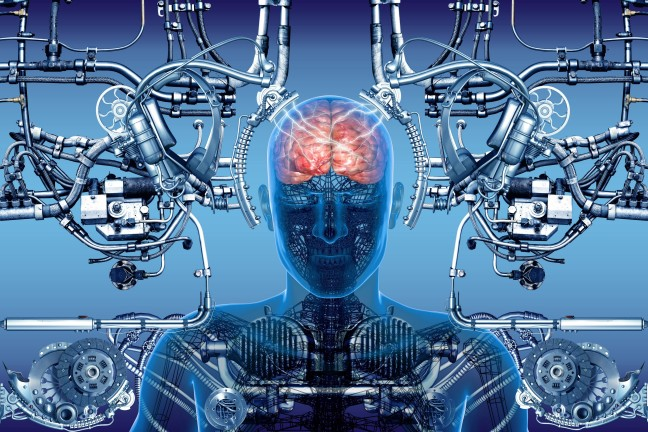

<h3><ins>5.1. Introduction</ins></h3><br>

Moving on from statistical Machine Learning models we now consider the `Recurrent Neural Network` architecture as a means of classifying disaster tweets. This type of neural model is known for its success in classifying (and generating) text data. 

Here we consider the tweets as `sequential` data, and by doing so we are saying that the order of words are important when it comes to classifying a tweet. We use a `many to one` category of sequence model, meaning we have a sequence of many data points and are classifying one label. 

The difference between a normal, fully-connected feedforward network and a `Recurrent Neural Net` is that an RNN's hidden layer recieves its input from both the input layer at the current time step, and the hidden layer from the previous time step. This allows the network to have a `memory of past events`, utilising `Long Short Term Memory Cells (LSTM)` to capture long range interactions. 


<br>

<br>

<h3><ins>5.2. Gathering All Tweets</ins></h3><br>

As with our statistical machine learning models, we must represent our tweets in numerical format to infer any meaningful predictions. This involves representing our tweets as vectors of scalar numbers, represented by a unique index number. These index numbers are created by compiling all of the unique words in our corpus(every tweet available) into a vocabualry. 

Once compiled, this vocabulary is used (along with some nifty `Tensorflow` wrappers) to convert each tweet into a series of its corresponding index numbers. This method of encoding our text is preferable to a one hot encoding approach (where our features == the size of the vocabulary, and each instance has a count of the number of times that word appears in a tweet). One of the issues with one hot encoding is that it produces a very sparse matrix, making it harder for the network to map inputs to outputs. 

<br>

In [30]:
unseen_text = unseen_data['text']
disaster_text = disaster_original['text']
all_tweets_concat = pd.concat([unseen_text, disaster_text], axis=0)

<br>

<h3><ins>5.3. Tensorflow Datasets</ins></h3><br>

Here we have maintained a low-level workflow, using in-built `Tensorflow` methods to create a dataframe from our csv. Although this involves a bit more programming, the benefits will be felt when the model enters production, as the preprocessing of textual data is baked into the model architecture. 

<br>

In [31]:
target = disaster_tweets.pop('target')
tweets_raw = tf.data.Dataset.from_tensor_slices((disaster_tweets.values, target.values))
tweets_unseen = tf.data.Dataset.from_tensor_slices((unseen_data.values))
unseen_raw_all = tf.data.Dataset.from_tensor_slices((all_tweets_concat.values))

<br>

Here we print out the first five instances to ensure that our data has been succesfully converted into a `Tensor`. 

<br>

In [32]:
for tw in tweets_raw.take(3):
    tf.print(tw[0].numpy()[0][ :50], tw[1])

b'deed reason earthquake may allah forgive u ' 1
b'forest fire near la ronge sask canada ' 1
b'resident ask place notify officer evacuation shelt' 1


<br>

<h3><ins>5.4. Training and Validation Sets</ins></h3><br>

Having gathered all of our data (features and labels) into a `Tensor` object, we can now go ahead and split this into seperate `training` and `validation` sets. Not only does this allow our model to check its accuracy after each epoch, it is also crucial to have these two scores to help diagnose `overfitting` or `underfitting`. Here we have opted for roughly 70 / 30 train/validation split, but as mentioned above this ratio has a direct impact on model performance and should be taken into consideration when optimising the model.  

<br>


In [33]:
tweets_raw = tweets_raw.shuffle(7613, reshuffle_each_iteration=False)
tweets_valid = tweets_raw.take(2283)
tweets_train = tweets_raw.skip(2283)

<br>

<h3><ins>5.5.Tokenise the Tweets</ins></h3><br>

Now we build our vocabulary of words, assigning each unique word an index and then using this to create tweet vectors for each of our tweets. Also demonstrated below is a short example of changing a sentence to a vector. 

Once complete, it's important that we use the low-level `Tensorflow` method `py_function`. This allows us to use the `map` method of dataset objects on a native `Tensorflow` data structure. The first function, `encode` treats the input tensors as if `eager execution` is enabled, allowing the second function, `encode_map_fn` to wrap the first and covert it to a `Tensorflow` operator.

As mentioned above, the benefit of such an approach means the preprocessing of text data is baked into the model, making for a more efficient, tidier deployment. 

<br>



In [34]:
tokeniser = tfds.features.text.Tokenizer()
token_counts = Counter()

for example in unseen_raw_all:
    tokens = tokeniser.tokenize(example.numpy())
    token_counts.update(tokens)

In [35]:
print(f"Vocab SIze: {len(token_counts)}")

Vocab SIze: 30551


In [36]:
encoder = tfds.features.text.TokenTextEncoder(token_counts)
example_string = "This is an example"
print(f"Exmaple String: {example_string}")
print(f"Encoded String: {encoder.encode(example_string)}")

Exmaple String: This is an example
Encoded String: [8654, 7929, 7925, 508]


<br>

<h3><ins>5.6. Map Vector Function</ins></h3><br>

The beauty of using the `py_function` call within `Tensorflow` is that it simply maps our function to the `Tensorflow data object`, meaning the conversion happens wihin the `.fit` and `.predict` method. Utilising our custom functions we can achieve this with one line of code for each of our datasets. 

<br>
    

In [37]:
tweets_train = tweets_train.map(encode_map_fn_train)
tweets_valid = tweets_valid.map(encode_map_fn_train)
tweets_unseen_map = tweets_unseen.map(encode_map_fn_unseen)

<br>

<h3><ins>5.7. Padding Our Sequences</ins></h3><br>

Our `Recurrent Neural Network` can handle input with different sequence lengths (tweets of varying size), however to process the `batches` properly we must ensure that each of the sequences in a batch are all matched in length. Thankfully, this is easily achieved using more `Tensorflow` operations.

Below we dictate how many instances per batch, then `Tensorflow` will automatically gather instances into batches, recording the size of the largest sequence in the batch and then padding the other instances accordingly. We demonstrate this function below before applying to our training, validation and unseen data. 

<br>

In [38]:
print("Example Sequences and their length:\n")
example = tweets_train.take(8)
for ex in example:
    print(f"Individual Size: {ex[0].shape}")

Example Sequences and their length:

Individual Size: (5,)
Individual Size: (5,)
Individual Size: (7,)
Individual Size: (7,)
Individual Size: (13,)
Individual Size: (5,)
Individual Size: (10,)
Individual Size: (5,)


In [39]:
print("Batched examples and the sequence length:\n")
batched_example = example.padded_batch(4, padded_shapes=([-1], []))
for batch in batched_example:
    print(f"Batch dimension: {batch[0].shape}")

Batched examples and the sequence length:

Batch dimension: (4, 7)
Batch dimension: (4, 13)


In [40]:
tweets_train = tweets_train.padded_batch(32, padded_shapes=([-1], []))
tweets_valid = tweets_valid.padded_batch(32, padded_shapes=([-1], []))
tweets_unseen_batched = tweets_unseen_map.padded_batch(32, padded_shapes=([-1], []))

<br>

<h3><ins>5.8. Recurrent Bidirectional Model</ins></h3><br>

With the preliminary steps complete we now start building our model, opting for a `bidirectional` architecture using `LSTM`. The `bidirectional` wrapper makes two passes over each input sequence (a forward pass and a backward pass), effectively allowing the model to examine the sequence in both directions. 

Initially we have opted for an `embedding dimension` size of 200 and a `Dropout` rate of 0.2 to help avoid `overfitting`. These parameters, together with the `Nadam` optimiser can all be tuned to achieve higher accuracy (as well as experimenting with various architectures). For now, we have opted for a simple network consisting of

1. An embedding layer.
2. A recurrenct LSTM layer in a bidirectional wrapper.
3. A fully connected layer.
4. A dropout layer.
5. A final fully connected output layer. 

The choice of activation function and weight initialisation will also have a direct affect on model performance and should be considered when optimising.

<br>

In [41]:
embedding_dimension = 200
vocab_size = len(token_counts) + 2

tf.random.set_seed(42)

bi_lstm_model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(
        
        input_dim=vocab_size,
        output_dim=embedding_dimension,
        name='embed-layer'),
    
    tf.keras.layers.Bidirectional(
        
        tf.keras.layers.LSTM(64, name='lstm-layer'),
        name='bidir-lstm'),
    
    
    
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
    
])

In [42]:
bi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 200)         6110600   
_________________________________________________________________
bidir-lstm (Bidirectional)   (None, 128)               135680    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 6,254,601
Trainable params: 6,254,601
Non-trainable params: 0
_________________________________________________________________


In [43]:
bi_lstm_model.compile(optimizer=tf.keras.optimizers.Nadam(1e-3),
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                     metrics=['accuracy'])

In [44]:
history = bi_lstm_model.fit_generator(tweets_train, validation_data=tweets_valid,
                           epochs=50, callbacks=[keras.callbacks.EarlyStopping(patience=8)])

Train for 167 steps, validate for 72 steps
Epoch 1/50
167/167 [==============================] - 16s 93ms/step - loss: 0.5394 - accuracy: 0.7341 - val_loss: 0.4522 - val_accuracy: 0.7919
Epoch 2/50
167/167 [==============================] - 10s 61ms/step - loss: 0.3450 - accuracy: 0.8576 - val_loss: 0.4711 - val_accuracy: 0.7849
Epoch 3/50
167/167 [==============================] - 9s 56ms/step - loss: 0.2408 - accuracy: 0.9090 - val_loss: 0.5691 - val_accuracy: 0.7827
Epoch 4/50
167/167 [==============================] - 9s 54ms/step - loss: 0.1652 - accuracy: 0.9383 - val_loss: 0.7270 - val_accuracy: 0.7687
Epoch 5/50
167/167 [==============================] - 9s 54ms/step - loss: 0.1157 - accuracy: 0.9553 - val_loss: 0.9036 - val_accuracy: 0.7551
Epoch 6/50
167/167 [==============================] - 10s 57ms/step - loss: 0.0809 - accuracy: 0.9659 - val_loss: 1.1302 - val_accuracy: 0.7459
Epoch 7/50
167/167 [==============================] - 9s 54ms/step - loss: 0.0625 - accuracy: 0.

<br>

<h3><ins>5.9. RNN Results</ins></h3><br>

Our initial model is performing similiarily to our statistical machine learning models with approx 78% accuracy on the validation set. Through examination of the `validation` and `accuracy` scores we can begin to diagnose the models shortcomings and aim to ahieve a higher accuracy of classification. 

<br>

In [45]:
predictions = history.model.predict_classes(tweets_unseen_batched, batch_size=None)

In [46]:
output_df = pd.DataFrame(unseen_id['id'])
output_df['target'] = predictions

In [47]:
out = output_df.to_csv('RNN.csv')

<br>

<h2><ins>6. Further Research</ins></h2><br>

With our `RNN` producing an acceptable baseline we can now begin exploring some improvements, such as:

1. Different embeddings.
2. RandomSearch wrapper to tune hyperparameters.
3. Further research on state-of-the-art architectures for document classification. 
4. Deep Convolutional Neural Network for detecting salient features at any point in the document. 


---